# Chest X-Ray Images (Pneumonia)

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow.keras                           import layers, models
from sklearn.model_selection                    import train_test_split
from sklearn.utils.class_weight                 import compute_class_weight
from tensorflow.keras.callbacks                 import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics                            import (classification_report, confusion_matrix, 
                                                        accuracy_score, precision_score, recall_score, 
                                                        f1_score, roc_auc_score)

## Загрузка данных

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def get_image_paths_and_labels(base_dir):
    data = []
    for split in ['train', 'val', 'test']:
        for label in ['NORMAL', 'PNEUMONIA']:
            folder = os.path.join(base_dir, split, label)
            for filename in os.listdir(folder):
                if filename.endswith('.jpeg'):
                    data.append({
                        'filepath': os.path.join(folder, filename),
                        'split': split,
                        'label': label
                    })
    return pd.DataFrame(data)

base_dir = "D:\ds\chest_xray"
df = get_image_paths_and_labels(base_dir)

df.head()

,filepath,split,label
0,D:\ds\chest_xray\train\NORMAL\IM-0115-0001.jpeg,train,NORMAL
1,D:\ds\chest_xray\train\NORMAL\IM-0117-0001.jpeg,train,NORMAL
2,D:\ds\chest_xray\train\NORMAL\IM-0119-0001.jpeg,train,NORMAL
3,D:\ds\chest_xray\train\NORMAL\IM-0122-0001.jpeg,train,NORMAL
4,D:\ds\chest_xray\train\NORMAL\IM-0125-0001.jpeg,train,NORMAL


## EDA
### Анализ распределения классов

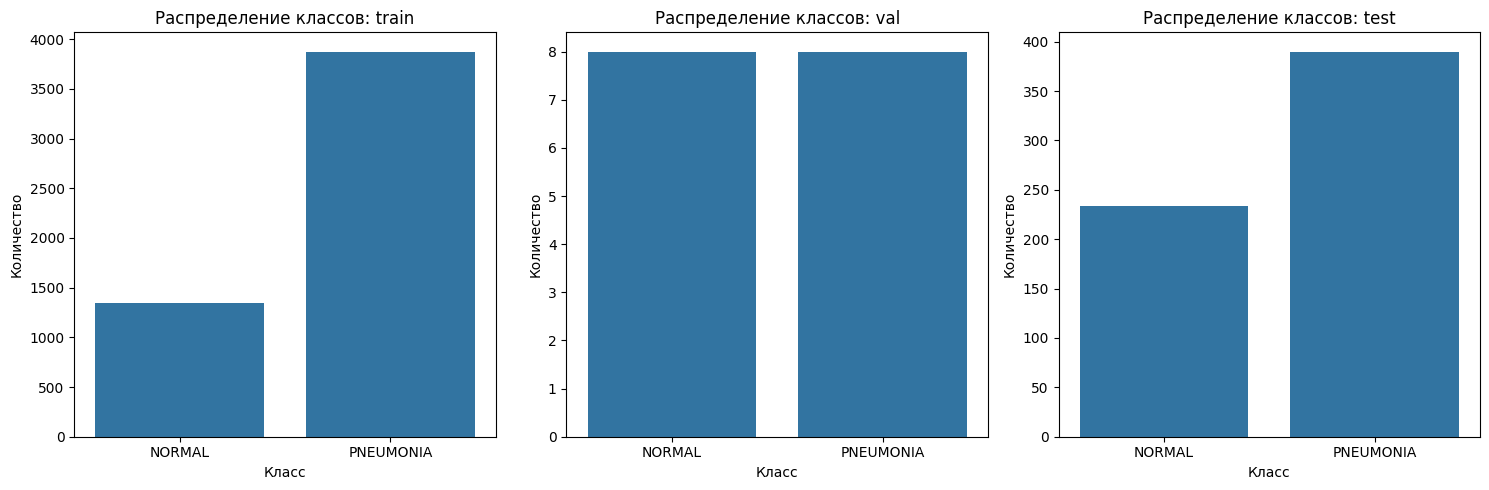

In [5]:
splits = df['split'].unique()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i, split in enumerate(splits):
    sns.countplot(data=df[df['split'] == split], x='label', ax=axes[i])
    axes[i].set_title(f'Распределение классов: {split}')
    axes[i].set_xlabel('Класс')
    axes[i].set_ylabel('Количество')

plt.tight_layout() 
plt.show()

Распределение классов по выборкам следующее:
- Обучающая выборка (`train`):
    - Normal: около 1500 изображений
    - Pneumonia: около 4000 изображений

- Валидационная выборка (`val`):
    - Normal: 8 изображений
    - Pneumonia: 8 изображений

- Тестовая выборка (`test`):
    - Normal: около 250 изображений
    - Pneumonia: около 400 изображений

**Выводы:**
- Дисбаланс классов в обучающей выборке очевиден: класс `Pneumonia` представлен в ~2.7 раза чаще, чем `Normal`. Это может привести к смещению модели в сторону более частого класса и недообучению на меньшем.
- Малый размер валидационной выборки (всего 16 изображений) вызывает сомнения в её пригодности для полноценной оценки качества модели в процессе обучения. Такая выборка может дать нестабильные и нерепрезентативные метрики.
- Дисбаланс классов желательно учесть:
    - Использовать взвешенную функцию потерь (`class_weight` в Keras).
    - Следить за `Recall` и `F1-score` для меньшего класса (`Normal`).
    - Можно попробовать аугментацию только для меньшего класса.
- Валидационную выборку стоит:
    - Или объединить с частью тренировочной и пересэмплировать, чтобы получить более репрезентативный валидационный сет (например, 10–15% от всего `train`).
    - Или явно использовать `k-fold cross-validation`.

### Визуализация снимков

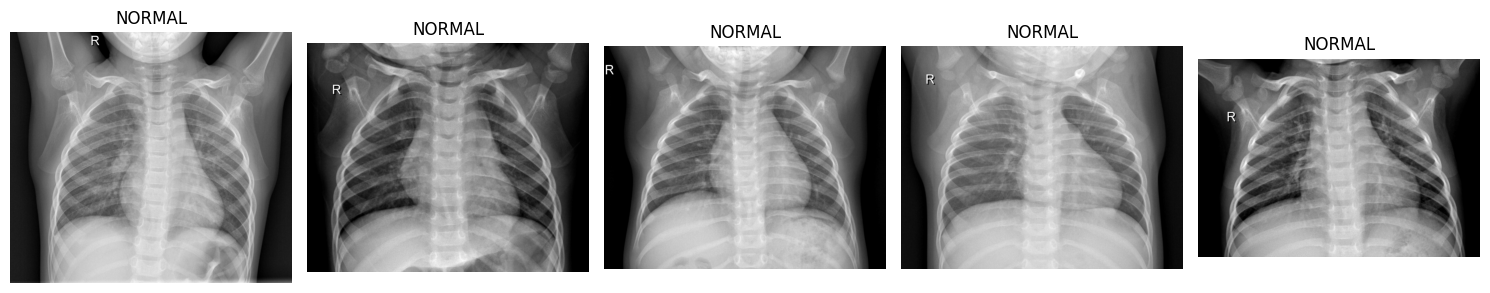

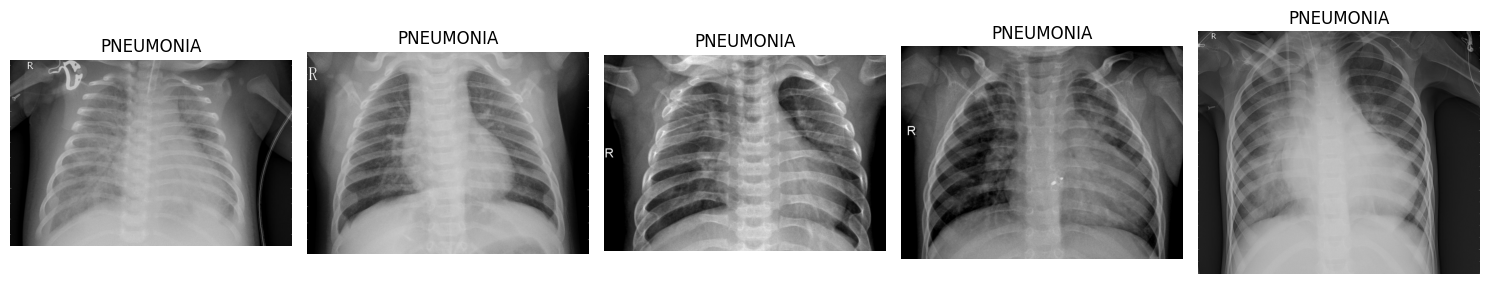

In [ ]:
def show_images(df_subset, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img = cv2.imread(df_subset.iloc[i]['filepath'], cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(df_subset.iloc[i]['label'])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(df[(df['label'] == 'NORMAL') & (df['split'] == 'train')], n=5)
show_images(df[(df['label'] == 'PNEUMONIA') & (df['split'] == 'train')], n=5)

### Распределение яркости и контрастности

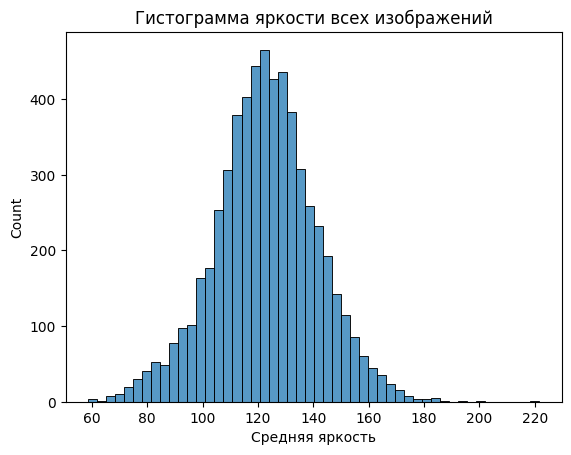

In [33]:
def compute_brightness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return -1
    return np.mean(img)

df['brightness'] = df['filepath'].apply(compute_brightness)

sns.histplot(df['brightness'], bins=50)
plt.title("Гистограмма яркости всех изображений")
plt.xlabel("Средняя яркость")
plt.show()

Обнаружено подозрительных изображений: 101


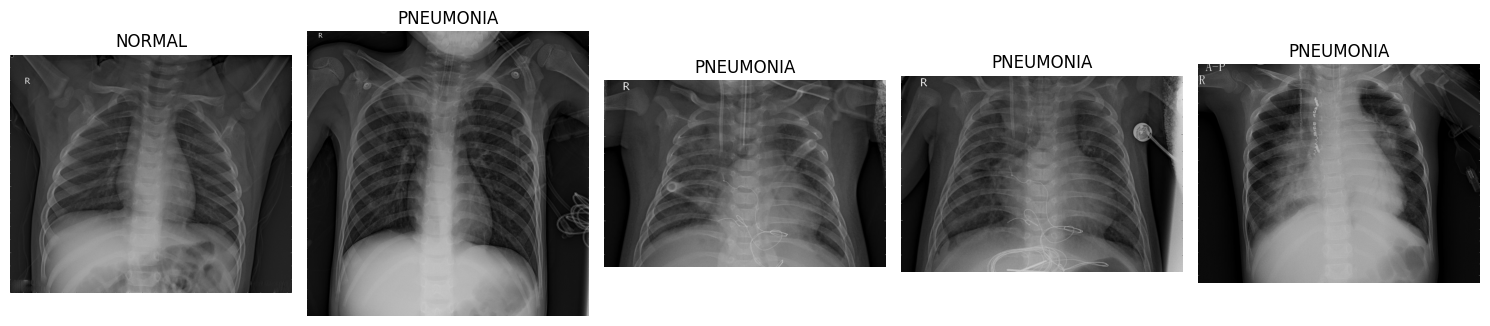

In [30]:
suspicious = df[(df['brightness'] < 80) | (df['brightness'] > 200)]
print(f"Обнаружено подозрительных изображений: {len(suspicious)}")
show_images(suspicious, n=5)

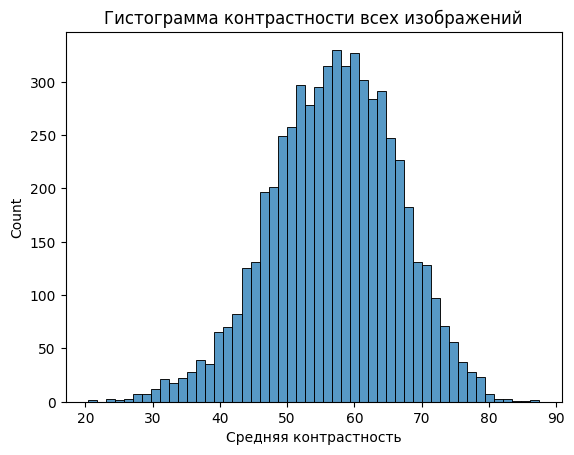

In [34]:
def compute_contrast(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return -1
    return np.std(img)

df['contrast'] = df['filepath'].apply(compute_contrast)

sns.histplot(df['contrast'], bins=50)
plt.title("Гистограмма контрастности всех изображений")
plt.xlabel("Средняя контрастность")
plt.show()

Обнаружено подозрительных изображений: 251


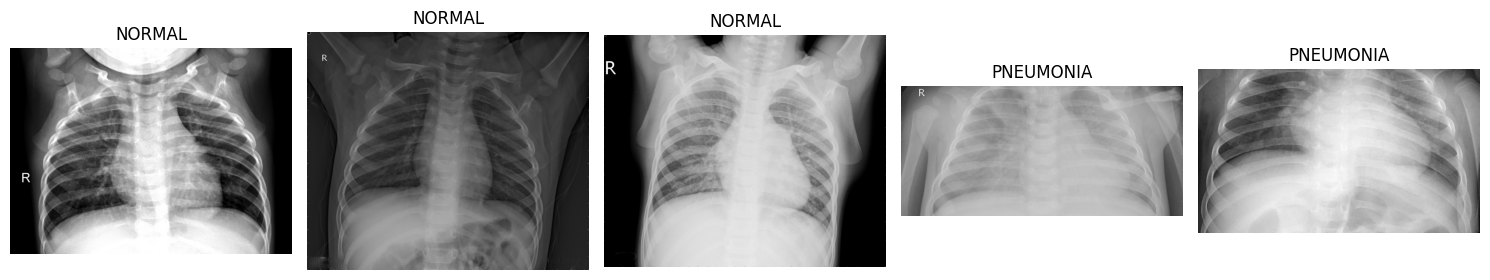

In [31]:
low_contrast = df[(df['contrast'] < 40) | (df['contrast'] > 80)]
print(f"Обнаружено подозрительных изображений: {len(low_contrast)}")

show_images(low_contrast, n=min(5, len(low_contrast)))

**Вывод:**
- Распределения яркости и контрастности изображений близки к нормальному. Небольшие хвосты, наблюдаемые на гистограммах, не содержат откровенно бракованных изображений, и, скорее всего, отражают естественное разнообразие данных (разные рентген-аппараты, пациенты, условия съёмки). В связи с этим решено не удалять такие снимки, чтобы не потерять потенциально значимую информацию для обобщающей способности модели.

## Предобработка данных

- `train_test_split` используется для выделения 15% от обучающей выборки под валидацию, таким образом дополним исходную выборку.
- итоговый `df_updated` объединяет все три части: обучающую, валидационную и тестовую.

In [22]:
train_df, val_df = train_test_split(df[df['split'] == 'train'], 
                                     test_size=0.15, 
                                     stratify=df[df['split'] == 'train']['label'], 
                                     random_state=42)

train_df['split'] = 'train'
val_df['split'] = 'val'

df_updated = pd.concat([train_df, val_df, df[df['split'] == 'test']], ignore_index=True)

In [23]:
train_df = df_updated[df_updated['split'] == 'train']
val_df   = df_updated[df_updated['split'] == 'val']
test_df  = df_updated[df_updated['split'] == 'test']

Загружаем изображение по пути `path`, декодируем его как чёрно-белое (`channels=1`).
- Приводим размер к `224×224` для стандартизации входа.
- Приводим значения пикселей к диапазону `[-1, 1]` для сочетания с входами сверточных нейросетей.

Если включена аугментация:
- Применяется **случайное отражение** по горизонтали.
- Применяется **случайный поворот** на `±10°`.
- Добавляется **гауссовский шум** для борьбы с переобучением.

In [ ]:
def load_and_preprocess(path, label, augment=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 127.5 - 1.0 

    if augment:
        image = tf.image.random_flip_left_right(image)
        angle = tf.random.uniform([], minval=-0.1745, maxval=0.1745)  
        image = tfa.image.rotate(image, angles=angle, interpolation='BILINEAR')
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
        image = tf.clip_by_value(image + noise, -1.0, 1.0) 

    return image, label

- Преобразуем датафрейм с путями к файлам и метками в `tf.data.Dataset`, совместимый с `TensorFlow pipeline`.
- Метки переводятся в бинарный формат: `NORMAL = 0`, остальные `= 1`.
- Внутри используется ранее определённая функция `load_and_preprocess` с возможностью аугментации.

**Оптимизация:**
- Используется `.map(..., num_parallel_calls=tf.data.AUTOTUNE)` — параллельная обработка ускоряет пайплайн.
- При необходимости перемешивания (`shuffle=True`) перемешивает весь датасет.
- Бейчится и подгружается с предвыборкой (`prefetch`) — повышает производительность во время обучения.

In [25]:
def df_to_dataset(df, batch_size=32, shuffle=True, augment=False):
    filepaths = df['filepath'].values
    labels = df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1).values

    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def process(path, label):
        return load_and_preprocess(path, label, augment=augment)

    ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [26]:
train_ds = df_to_dataset(train_df, batch_size=32, shuffle=True, augment=True)
val_ds   = df_to_dataset(val_df, batch_size=32, shuffle=False, augment=False)
test_ds  = df_to_dataset(test_df, batch_size=32, shuffle=False, augment=False)

## Базовая модель

Считаем веса классов с помощью `compute_class_weight`.

In [9]:
y_train = train_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1).values
classes = np.unique(y_train)

class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.9442982456140352, 1: 0.6730944427573641}


**Базовая CNN-модель:**

- Вход: ч/б изображение `224×224×1`.
- Слои:
  - 3 сверточных блока: `Conv2D → MaxPooling2D` с увеличением фильтров (`32 → 128`).
  - Завершается `GlobalAveragePooling2D` (снижает количество параметров).
  - Полносвязный слой на 128 нейронов с `Dropout 0.3` (предотвращает переобучение).
  - Выходной слой с `sigmoid` для бинарной классификации.

In [ ]:
def build_cnn_model(input_shape=(224, 224, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

- Всего параметров: ~109k 
- Все параметры обучаемые — нет замороженных слоев
- Размеры тензоров после свёрток и пуллингов показывают постепенное уменьшение пространственных размеров (`224 → 26`), при этом увеличивается число каналов (`1 → 128`).

In [13]:
model = build_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

- Оптимизатор — `Adam`.
- Функция потерь — бинарная кросс-энтропия.
- В `fit`:
  - Используется `class_weight`, чтобы компенсировать дисбаланс классов.
  - `EarlyStopping` с `patience=3` — прерывает обучение, если валид.метрика не улучшается 3 эпохи подряд.
  - `restore_best_weights=True` — восстанавливает лучшие веса по результатам валидации.

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=3, 
            restore_best_weights=True
        )
    ]
)

Epoch 1/15
139/139 [==============================] - 20s 85ms/step - loss: 0.6523 - accuracy: 0.5200 - precision: 0.8511 - recall: 0.4288 - auc: 0.6741 - val_loss: 0.4699 - val_accuracy: 0.8352 - val_precision: 0.9729 - val_recall: 0.8007 - val_auc: 0.9215
Epoch 2/15
139/139 [==============================] - 17s 81ms/step - loss: 0.3913 - accuracy: 0.8301 - precision: 0.9491 - recall: 0.8151 - auc: 0.9050 - val_loss: 0.2950 - val_accuracy: 0.8825 - val_precision: 0.9422 - val_recall: 0.8969 - val_auc: 0.9378
Epoch 3/15
139/139 [==============================] - 18s 82ms/step - loss: 0.3097 - accuracy: 0.8662 - precision: 0.9646 - recall: 0.8512 - auc: 0.9363 - val_loss: 0.2851 - val_accuracy: 0.8774 - val_precision: 0.9620 - val_recall: 0.8694 - val_auc: 0.9474
Epoch 4/15
139/139 [==============================] - 18s 82ms/step - loss: 0.2982 - accuracy: 0.8667 - precision: 0.9662 - recall: 0.8503 - auc: 0.9397 - val_loss: 0.2706 - val_accuracy: 0.8825 - val_precision: 0.9676 - val_r

In [15]:
def evaluate_model(model, dataset):
    y_true = []
    y_pred_probs = []
    y_pred = []
    
    for images, labels in dataset:
        probs = model.predict(images)
        y_pred_probs.extend(probs.flatten())
        preds = (probs > 0.5).astype(int).flatten()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

evaluate_model(model, test_ds)

1/1 [==============================] - 0s 88ms/step
Accuracy: 0.7692
Precision: 0.7606
Recall: 0.9205
F1 Score: 0.8329
ROC AUC: 0.8605


Судя по высокому `Recall` и относительно низкому `Precision`, дисбаланс классов даёт о себе знать и модель склонна чаще определять пневмонию. `ROC AUC` составляет `0.86`. Посмотрим, удастся ли улучшить метрику, усложнив сеть.

## Улучшенная модель

- 5 сверточных блоков с увеличением числа фильтров (`32 → 512`). 
- `BatchNormalization` после каждого свёрточного слоя.
- `ReLU` для активации.
- `MaxPooling 2x2` - cокращает пространственные размеры, увеличивая поле восприятия.
- `Dropout` с ростом вероятности: начинается с `0.25`, постепенно увеличивается до `0.5` к глубоким слоям и `0.4` перед полносвязным.
- `Flatten + Dense (256) + Dropout (0.4)`: переводит сверточные признаки в вектор, а полносвязный слой с дропаутом помогает моделировать сложные зависимости и дополнительно регуляризирует.
- Выходной слой с активацией `sigmoid`

In [ ]:
def build_custom_cnn():
    inputs = layers.Input(shape=(224, 224, 1))
    x = inputs

    # Блок 1
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Блок 2
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Блок 3
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)

    # Блок 4
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Блок 5
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

`Focal Loss` — это модификация бинарной кросс-энтропии, которая фокусируется на сложных для классификации примерах, снижая вклад легких примеров.
  - `alpha` регулирует вес класса, помогает бороться с дисбалансом между классами.  
  - `gamma` усиливает эффект фокусировки на ошибках.
  - `p_t` — вероятность правильного предсказания для каждого примера (чем больше — тем увереннее модель).  
  - `modulating_factor` `(1 - p_t)^γ` — уменьшает вес для уже хорошо предсказанных примеров.  
  - `alpha_factor` — балансировка влияния классов.
  - `tf.keras.backend.clip` для защиты от вычислительных ошибок логарифма при значениях 0 или 1.  
  - Усреднение по батчу через `reduce_mean`.

In [ ]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow((1 - p_t), gamma)

        return tf.reduce_mean(alpha_factor * modulating_factor * bce)
    return loss

In [11]:
model = build_custom_cnn()
model.compile(optimizer='adam',
              loss=focal_loss(alpha=0.25, gamma=2.0),
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',   # следим за валидацией
    patience=5,           # если 5 эпох без улучшения — стоп
    restore_best_weights=True,  # откат к лучшей модели
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # уменьшаем lr в 2 раза
    patience=3,          # если 3 эпохи нет прогресса — уменьшаем
    min_lr=1e-6,         # не опускаться ниже этой границы
    verbose=1
)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
139/139 [==============================] - 34s 186ms/step - loss: 0.4648 - accuracy: 0.6607 - auc: 0.7405 - val_loss: 0.1025 - val_accuracy: 0.7433 - val_auc: 0.8854 - lr: 0.0010
Epoch 2/50
139/139 [==============================] - 32s 187ms/step - loss: 0.0383 - accuracy: 0.7128 - auc: 0.9015 - val_loss: 0.0805 - val_accuracy: 0.7433 - val_auc: 0.9216 - lr: 0.0010
Epoch 3/50
139/139 [==============================] - 33s 191ms/step - loss: 0.0374 - accuracy: 0.8689 - auc: 0.9133 - val_loss: 0.2932 - val_accuracy: 0.7433 - val_auc: 0.9306 - lr: 0.0010
Epoch 4/50
139/139 [==============================] - 34s 196ms/step - loss: 0.0344 - accuracy: 0.8888 - auc: 0.9341 - val_loss: 0.1691 - val_accuracy: 0.7433 - val_auc: 0.9703 - lr: 0.0010
Epoch 5/50
139/139 [==============================] - 33s 190ms/step - loss: 0.0287 - accuracy: 0.9129 - auc: 0.9517 - val_loss: 0.0780 - val_accuracy: 0.8008 - val_auc: 0.9794 - lr: 0.0010
Epoch 6/50
139/139 [==============================

20/20 [==============================] - 1s 60ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.9420    0.2778    0.4290       234
           1     0.6955    0.9897    0.8169       390

    accuracy                         0.7228       624
   macro avg     0.8188    0.6338    0.6230       624
weighted avg     0.7879    0.7228    0.6715       624

ROC AUC: 0.9104


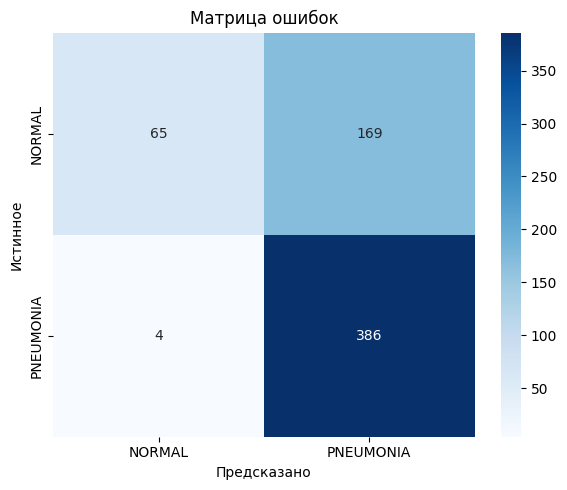

In [28]:
# Получим предсказания и реальные метки
y_true = test_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1).values
y_pred_probs = model.predict(test_ds).ravel()
y_pred = (y_pred_probs >= 0.5).astype(int)

# 1. Классический отчёт
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# 2. ROC AUC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"ROC AUC: {auc:.4f}")

# 3. Матрица ошибок
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Матрица ошибок")
plt.xlabel("Предсказано")
plt.ylabel("Истинное")
plt.tight_layout()
plt.show()

## Финальный вывод

- **Точность (Precision):**  
  Улучшенная модель значительно повысила `precision` для класса 0 (нормальные случаи), почти до 94%, в то время как базовая модель дала более сбалансированные, но менее высокие показатели.

- **Полнота (Recall):**  
  Для класса 1 (пневмония) улучшенная модель почти идеально обнаруживает все положительные случаи (`Recall` 98.97%), однако для класса 0 полнота упала сильно — 27.78%, что говорит о большом числе ложных отрицаний.

- **F1-score:**  
  Улучшенная модель достигла хорошего F1 у класса 1 (~0.82), но у класса 0 — очень низкий (0.43). Это говорит о сильном перекосе модели в пользу класса 1.

- **Accuracy:**  
  Несмотря на улучшение AUC, точность модели по всем классам упала с 0.77 до 0.72. Это связано с плохой полнотой по классу 0.

- **ROC AUC:**  
  Улучшенная модель показывает лучший `ROC AUC` (0.91 против 0.86), что означает, что она лучше ранжирует положительные и отрицательные примеры в целом.

---
Улучшенная модель стала лучше выявлять случаи пневмонии (класс 1), что критично для минимизации пропущенных диагнозов, но при этом сильно ухудшила распознавание нормальных пациентов (класс 0). 

Если цель — минимизировать пропуски пневмонии, улучшенная модель подходит лучше. Если же баланс важен — стоит дополнительно поработать над настройкой модели, подбором порога и, возможно, использовать методы балансировки классов или ансамбли.